In [4]:
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 

data = pd.read_csv("./dataset/hmnist_28_28_RGB.csv")
data.head()
meta_df = pd.read_csv("./dataset/HAM10000_metadata.csv")
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
meta_df.shape
data.shape

(10015, 2353)

In [6]:
yData = data['label']
XData = data.drop(columns = ['label'])
# EDA
distribution = meta_df['dx'].value_counts()
distribution
# classes = {4: ('nv', ' Nevus'),
#            6: ('mel', 'Melanoma'),
#            2 :('bkl', 'Seborrheic Keratosis'), 
#            1:('bcc' , ' Basal Cell Carcinoma '),
#            5: ('vasc', 'Vascular Lesion'),
#            0: ('akiec', 'Actinic Keratosis'),
#            3: ('df', 'Dermatofibroma')}

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

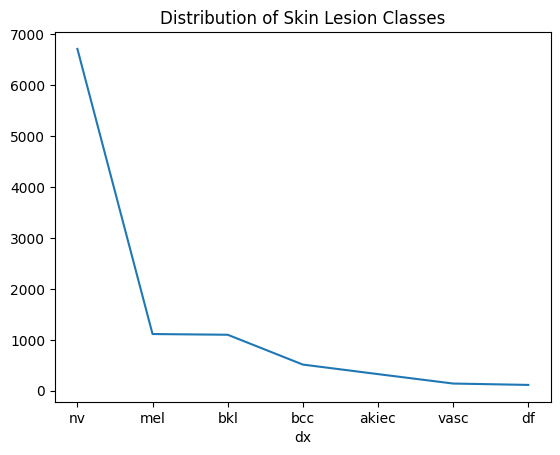

In [7]:
dist = data['label'].value_counts()
dist
distribution.plot()
plt.title('Distribution of Skin Lesion Classes')
plt.show()

In [9]:
# Fixing Data Imbalance
from imblearn.over_sampling import RandomOverSampler 
sampler = RandomOverSampler()
XData,yData  = sampler.fit_resample(XData,yData)
XData.shape, yData.shape
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255
XData.shape

(46935, 28, 28, 3)

In [10]:
# Creating the train and validation set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)
Xtrain.shape, Xtest.shape

((37548, 28, 28, 3), (9387, 28, 28, 3))

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, ZeroPadding2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

input_shape = (28, 28, 3) 
num_classes = 7

# Custom CNN

In [12]:
# Convolution Block
def conv_block(x, filters, kernel_size, strides=1, padding='same'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# Identity Block (used in ResNet for residual connections)
def identity_block(x, filters):
    skip = x
    x = conv_block(x, filters, 3)
    x = conv_block(x, filters, 3)
    x = layers.Add()([x, skip])
    return x

# Dense Block (used in DenseNet)
def dense_block(x, num_layers, growth_rate):
    for i in range(num_layers):
        layer = conv_block(x, growth_rate, 3)
        x = layers.Concatenate()([x, layer])
    return x

# Transition Block (used in DenseNet to reduce dimensions)
def transition_block(x, filters):
    x = layers.Conv2D(filters, 1, padding='same')(x)
    x = layers.AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

# Define the Hybrid CNN model
def hybrid_cnn_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Convolution and Pooling layers
    x = conv_block(inputs, 64, 7, strides=2)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Conv Block A, B, and C (Conv blocks can be repeated with different filters)
    x = conv_block(x, 64, 3)
    x = conv_block(x, 128, 3)
    x = conv_block(x, 256, 3)

    # Adding an Identity Block (ResNet style)
    x = identity_block(x, 256)

    # Transition Block
    x = transition_block(x, 128)

    # Dense Block (Growth rate 32 and 6 layers in this example)
    x = dense_block(x, 6, 32)

    # Pooling (Averaging)
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected (FC) Layer
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer with Softmax for multi-class classification
    outputs = layers.Dense(7, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs, outputs)

    return model


HybridCNN = hybrid_cnn_model(input_shape, num_classes)

HybridCNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
history = HybridCNN.fit(Xtrain,
                    Ytrain,
                    epochs = 20,
                    validation_data = (Xtest, Ytest))

Epoch 1/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 150s 119ms/step - accuracy: 0.4637 - loss: 1.4054 - val_accuracy: 0.4774 - val_loss: 1.8344
Epoch 2/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 138s 117ms/step - accuracy: 0.6954 - loss: 0.8281 - val_accuracy: 0.5493 - val_loss: 1.2217
Epoch 3/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 145s 123ms/step - accuracy: 0.7668 - loss: 0.6281 - val_accuracy: 0.4541 - val_loss: 2.2709
Epoch 4/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 143s 122ms/step - accuracy: 0.8113 - loss: 0.5038 - val_accuracy: 0.5949 - val_loss: 1.6437
Epoch 5/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 144s 123ms/step - accuracy: 0.8451 - loss: 0.4167 - val_accuracy: 0.3558 - val_loss: 4.1371
Epoch 6/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 145s 123ms/step - accuracy: 0.8675 - loss: 0.3561 - val_accuracy: 0.5996 - val_loss: 1.8120
Epoch 7/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 145s 123ms/step - accuracy: 0.8877 - loss: 0.3042 - val_accuracy: 0.6270 - val_loss: 1.4673
Epoch 8/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 146s 124ms/step - ac

In [15]:
from tabulate import tabulate

loss_hybrid_cnn, accuracy_hybrid_cnn = HybridCNN.evaluate(Xtest, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_hybrid_cnn * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_hybrid_cnn)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.8206 - loss: 0.7740
+---------------+--------+
| Test Accuracy | 81.84% |
+---------------+--------+
| Test Loss     | 0.7921 |
+---------------+--------+


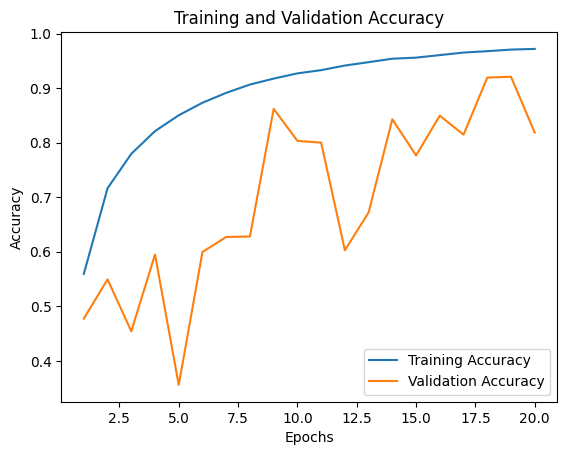

In [16]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

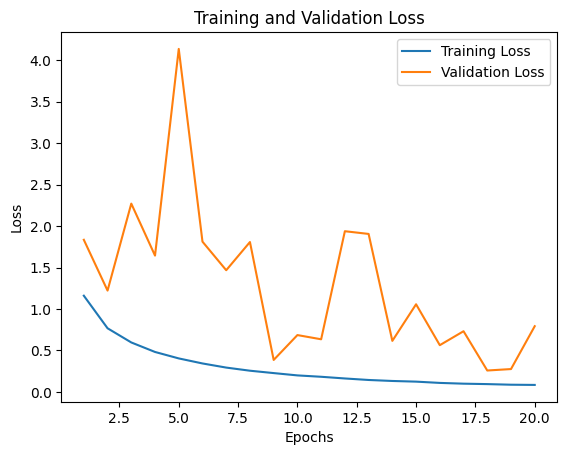

In [17]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# DermaNet

In [18]:
inputs = Input(shape=input_shape)
derma_net = Conv2D(32, (2, 2), padding='same')(inputs)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)
derma_net = MaxPooling2D(pool_size=(2, 2))(derma_net)

derma_net = Conv2D(32, (2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)
derma_net = MaxPooling2D(pool_size=(2, 2))(derma_net)

derma_net = Conv2D(64, (2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)
derma_net = MaxPooling2D(pool_size=(2, 2))(derma_net)

derma_net = SeparableConv2D(128, (2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)
derma_net = SpatialDropout2D(0.2)(derma_net)
derma_net = MaxPooling2D(pool_size=(2, 2))(derma_net)

# Upsampling Layers
derma_net = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)

derma_net = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)

# Global Average Pooling
derma_net = GlobalAveragePooling2D()(derma_net)

# Dense Layers
derma_net = Dense(128)(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = Dropout(0.5)(derma_net)

# More Dense Layers
derma_net = Dense(128)(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = Dropout(0.5)(derma_net)

derma_net = Dense(128)(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = Dropout(0.5)(derma_net)

outputs = Dense(7)(derma_net)
outputs = Activation('softmax')(outputs)

DermaNet = Model(inputs=inputs, outputs=outputs)

DermaNet.compile(loss='sparse_categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])

In [20]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/skin.keras',
                                              monitor='val_acc', mode='max',
                                              verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [21]:
history = DermaNet.fit(Xtrain,
                    Ytrain,
                    epochs = 50,
                    validation_data = (Xtest, Ytest),
                    callbacks=[callback, early_stopping])

Epoch 1/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4987 - loss: 1.2813
Epoch 1: saving model to /kaggle/working/skin.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 67s 46ms/step - accuracy: 0.4988 - loss: 1.2811 - val_accuracy: 0.7330 - val_loss: 0.6786
Epoch 2/50
1173/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7506 - loss: 0.6867
Epoch 2: saving model to /kaggle/working/skin.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 63s 54ms/step - accuracy: 0.7507 - loss: 0.6866 - val_accuracy: 0.8138 - val_loss: 0.4798
Epoch 3/50
1173/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8203 - loss: 0.5047
Epoch 3: saving model to /kaggle/working/skin.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - accuracy: 0.8203 - loss: 0.5046 - val_accuracy: 0.8303 - val_loss: 0.4343
Epoch 4/50
1173/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8505 - loss: 0.4211
Epoch 4: saving model to /kaggle/working/skin.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 69s 59ms/step - accuracy: 0.8505 - loss: 0

In [22]:
from tabulate import tabulate

loss_dermanet, accuracy_dermanet = DermaNet.evaluate(Xtest, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_dermanet * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_dermanet)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9708 - loss: 0.0865
+---------------+--------+
| Test Accuracy | 97.22% |
+---------------+--------+
| Test Loss     | 0.0833 |
+---------------+--------+


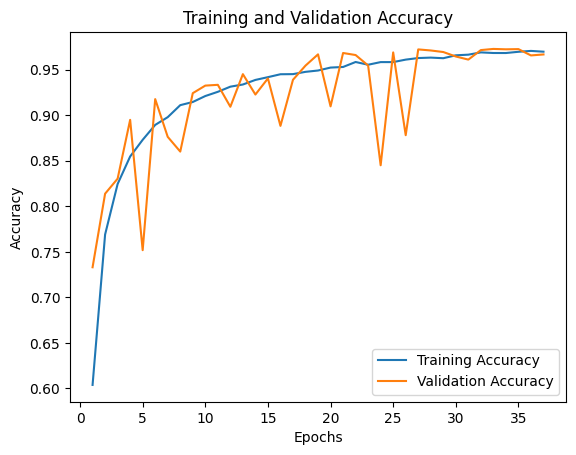

In [23]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

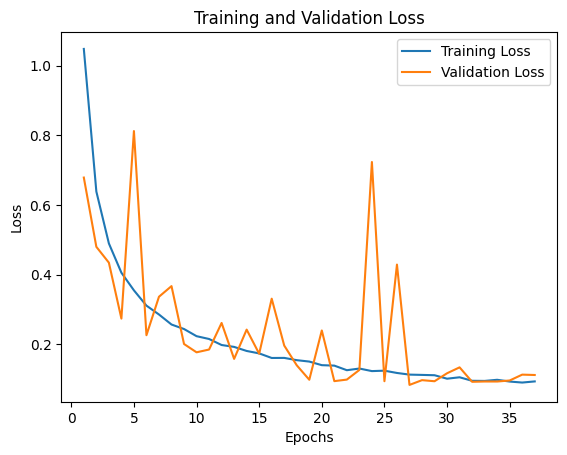

In [24]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# EfficientNet

In [25]:
Xtrain_resized = tf.image.resize(Xtrain, (32, 32))
Xtest_resized = tf.image.resize(Xtest, (32, 32))

In [26]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  

Efficientnet = Model(inputs=base_model.input, outputs=predictions)

Efficientnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 13s 1us/step


In [27]:
history = Efficientnet.fit(Xtrain_resized, Ytrain, 
                           validation_data=(Xtest_resized, Ytest), 
                           epochs=10)

Epoch 1/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 504s 325ms/step - accuracy: 0.5971 - loss: 1.1241 - val_accuracy: 0.7973 - val_loss: 0.5669
Epoch 2/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 350s 298ms/step - accuracy: 0.8244 - loss: 0.4834 - val_accuracy: 0.8493 - val_loss: 0.4767
Epoch 3/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 356s 303ms/step - accuracy: 0.8819 - loss: 0.3345 - val_accuracy: 0.8697 - val_loss: 0.3720
Epoch 4/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 335s 285ms/step - accuracy: 0.8986 - loss: 0.2873 - val_accuracy: 0.8963 - val_loss: 0.2962
Epoch 5/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 320s 273ms/step - accuracy: 0.9181 - loss: 0.2461 - val_accuracy: 0.9210 - val_loss: 0.2251
Epoch 6/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 8007s 7s/step - accuracy: 0.9317 - loss: 0.2040 - val_accuracy: 0.9507 - val_loss: 0.1536
Epoch 7/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 186s 159ms/step - accuracy: 0.9372 - loss: 0.1922 - val_accuracy: 0.9003 - val_loss: 0.3086
Epoch 8/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 215s 183ms/step - accu

In [28]:
from tabulate import tabulate

loss_efficientnet, accuracy_efficientnet = Efficientnet.evaluate(Xtest_resized, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_efficientnet * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_efficientnet)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9619 - loss: 0.1164
+---------------+--------+
| Test Accuracy | 96.22% |
+---------------+--------+
| Test Loss     | 0.1192 |
+---------------+--------+


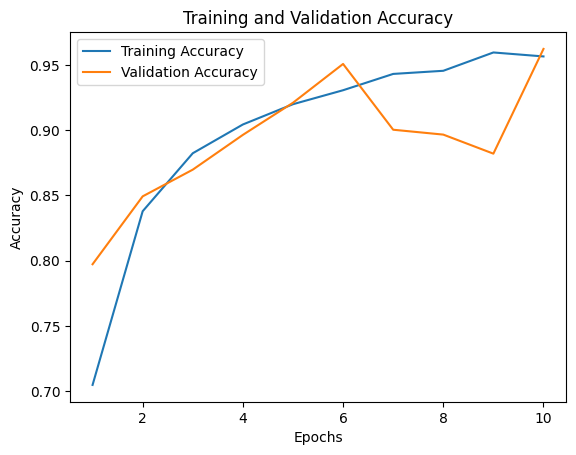

In [29]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


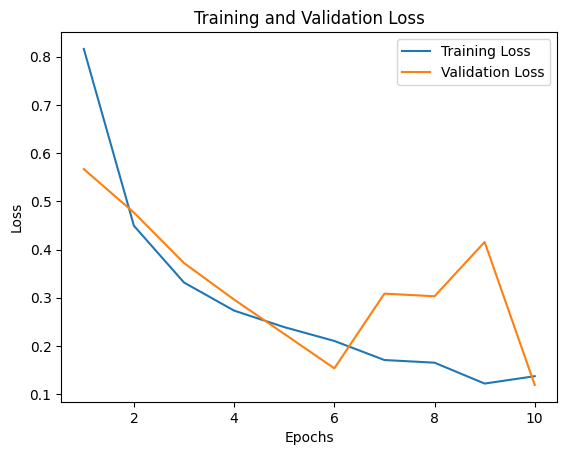

In [30]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Resnet50

In [31]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

Resnet = Model(inputs=base_model.input, outputs=predictions)

Resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 103s 1us/step


In [34]:
history = Resnet.fit(Xtrain_resized, Ytrain, 
                           validation_data=(Xtest_resized, Ytest), 
                           epochs=10)

Epoch 1/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 515s 439ms/step - accuracy: 0.7879 - loss: 0.5929 - val_accuracy: 0.7617 - val_loss: 0.6979
Epoch 2/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 504s 429ms/step - accuracy: 0.8080 - loss: 0.5161 - val_accuracy: 0.8220 - val_loss: 0.4806
Epoch 3/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 493s 420ms/step - accuracy: 0.8513 - loss: 0.4192 - val_accuracy: 0.8468 - val_loss: 0.3871
Epoch 4/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 484s 412ms/step - accuracy: 0.8375 - loss: 0.4805 - val_accuracy: 0.9068 - val_loss: 0.2763
Epoch 5/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 482s 410ms/step - accuracy: 0.9248 - loss: 0.2101 - val_accuracy: 0.9271 - val_loss: 0.2175
Epoch 6/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 478s 407ms/step - accuracy: 0.9211 - loss: 0.2298 - val_accuracy: 0.4998 - val_loss: 2.6460
Epoch 7/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 541s 461ms/step - accuracy: 0.9131 - loss: 0.2531 - val_accuracy: 0.9262 - val_loss: 0.2176
Epoch 8/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 594s 506ms/step - ac

In [33]:
from tabulate import tabulate

loss_resnet, accuracy_resnet = Resnet.evaluate(Xtest_resized, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_resnet * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_resnet)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.2898 - loss: 3.7097
+---------------+--------+
| Test Accuracy | 27.70% |
+---------------+--------+
| Test Loss     | 3.8775 |
+---------------+--------+


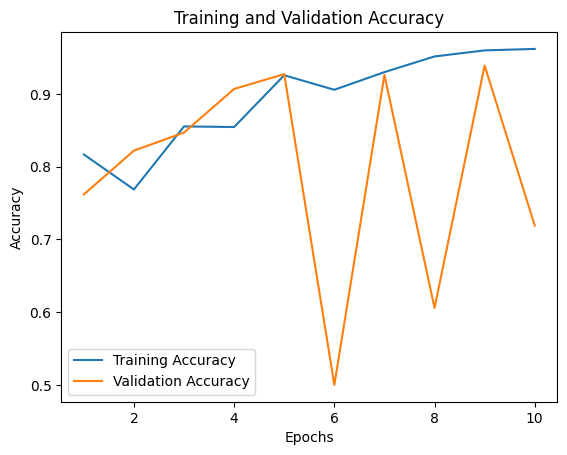

In [35]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

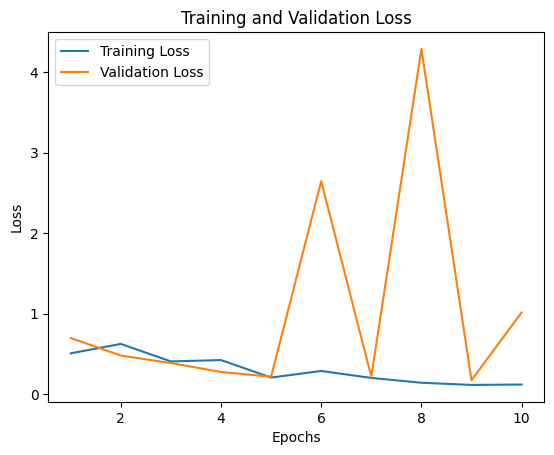

In [36]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

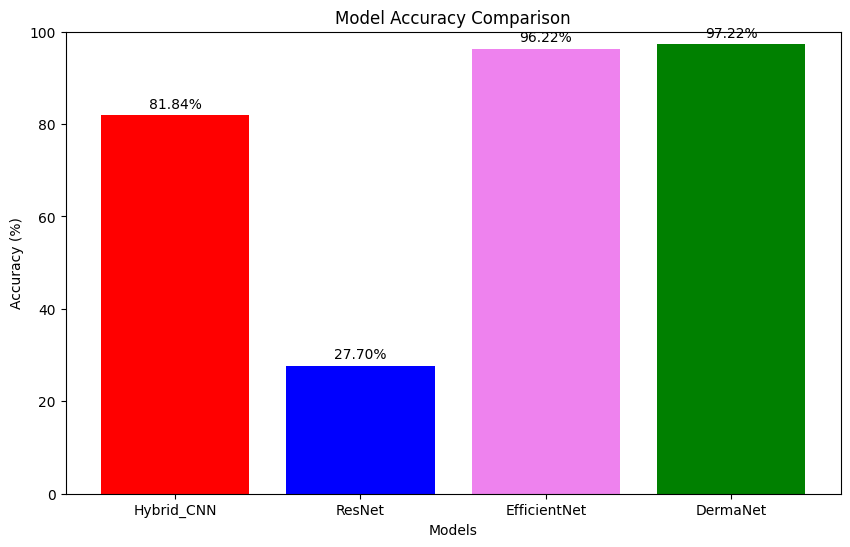

In [37]:
import matplotlib.pyplot as plt

accuracies = [accuracy_hybrid_cnn*100, accuracy_resnet*100, accuracy_efficientnet*100 , accuracy_dermanet*100]
models = ['Hybrid_CNN', 'ResNet', 'EfficientNet' ,"DermaNet"]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['red', 'blue', 'violet','green'])

plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.ylim(0, 100)
plt.show()